# Group Theory Homework: A Study of Point Group Symmetries in Molecules

A notebook that lays out plainly all the code used to complete the associated homework assg. Written by Theo N. Dionne.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

## Calculating the decomposition of the mechanical reps

### Functions

In [2]:
def get_irrep_multiplicity(representation_characters, character_table, elements_per_class):
   """A function that gets the multiplicity of each irrep 
   for real representations using the magic formula.

      Arguments:
         representation_characters (np.array((# classes), dtype=float)) : characters of the rep to decompose.
         character_table (np.array((# classes, # classes), dtype=float)) : character table; line->irrep, col->class.
         elements_per_class (np.array((# classes), dtype=int)) : # elements per class

      Returns:
         multiplicity_vector (np.array((# irreps), dtype=int)) : multiplicities for each irreps in provided rep.
    """
   # multiply each character by the number of elements in its class
   representation_characters_adjusted = representation_characters*elements_per_class

   # perform a matrix multiplication between the character table and divide by group size
   multiplicity_vector = character_table @ representation_characters_adjusted / np.sum(elements_per_class)

   return multiplicity_vector

### AB4 (C4v) Decomposition

In [3]:
# define the character table of the PG
character_table_C4v = np.array([
    [1, 1, 1, 1, 1],
    [1, 1, 1,-1,-1],
    [1, 1,-1, 1,-1],
    [1, 1,-1,-1, 1],
    [2,-2, 0, 0, 0]
])  

# define the number of elements per class
elements_per_class_C4v = np.array([1,1,2,2,2])

# the characters of the mechanical representation
M_characters_C4v = np.array([15,-1,1,1,3])

# Getting and printing the mutliplicities
M_multiplicities_C4v = get_irrep_multiplicity(M_characters_C4v, character_table_C4v, elements_per_class_C4v)
print(M_multiplicities_C4v) # in the same order as the table in the pdf

[3. 1. 1. 2. 4.]


### UF6 (Oh) Decomposition

In [4]:
# define the character table of the PG
character_table_Oh = np.array([
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1,-1,-1,-1,-1,-1],
[1, 1,-1,-1, 1, 1, 1,-1,-1, 1],
[1, 1,-1,-1, 1,-1,-1, 1, 1,-1],
[2, 2, 0, 0,-1, 2, 2, 0, 0,-1],
[2, 2, 0, 0,-1,-2,-2, 0, 0, 1],
[3,-1, 1,-1, 0, 3,-1, 1,-1, 0],
[3,-1, 1,-1, 0,-3, 1,-1, 1, 0],
[3,-1,-1, 1, 0, 3,-1,-1, 1, 0],
[3,-1,-1, 1, 0,-3, 1, 1,-1, 0]
])  

# define the number of elements per class
elements_per_class_Oh = np.array([1, 3, 6, 6, 8, 1, 3, 6, 6, 8])

# the characters of the mechanical representation
M_characters_Oh = np.array([21,-3, 3,-1, 0,-3, 5,-1, 3, 0])

# Getting and printing the mutliplicities
M_multiplicities_Oh = get_irrep_multiplicity(M_characters_Oh, character_table_Oh, elements_per_class_Oh)
print(M_multiplicities_Oh) # in the same order as the table in the pdf

[1. 0. 0. 0. 1. 0. 1. 3. 1. 1.]


## Getting symmetry adapted modes

In [ ]:
# functions

def _get_swap_matrices(atom_coordinates, vector_rep):
    """A function that gets the matrices (swap matrices) that define 
    how the atoms are swapped under the action of the group.
    
    Arguments:
        atom_coordinates (np.array((3, # atoms), dtype=float)) : the cartesian coordinates for the atoms.
        vector_rep (np.array((# group elements, 3, 3), dtype=float)) : array of matrices for the vector rep.

    Returns:
        swap_matrices (np.array((# group elements, # atoms, # atoms), dtype=int)) the permutation matrix allowing
            to represent the action of the group elements on the atoms.
        number_of_operations (int) : # elements in the group.
        number_of_atoms (int) : # atoms.
    """

    # generate empty swap matrix array
    number_of_operations = np.shape(vector_rep)[0] # number of group elements considered
    number_of_atoms = np.shape(atom_coordinates)[1] # number of atoms considered
    swap_matrices = np.zeros((number_of_operations, number_of_atoms, number_of_atoms))

    # applies every transformation to the atom coordinates
    transformed_coordinates = vector_rep @ atom_coordinates

    for i in range(number_of_operations):
        for j in range(number_of_atoms):
            for k in range(number_of_atoms):
                norm_transformed_minus_reference = np.linalg.norm(transformed_coordinates[i,:,k] - atom_coordinates[:,j])
                if norm_transformed_minus_reference == 0:
                    # set swap matrix
                    swap_matrices[i,j,k] = 1
                    break
        
    return swap_matrices, number_of_operations, number_of_atoms


def get_mechanical_representation(atom_coordinates, vector_rep):
    """A function that calculates the mechanical representation based off the fact 
    that M = S \\otimes V where S is the swap matrix and V is the vector representation"""

    # obtain swap matrices
    swap_matrices, number_of_operations, number_of_atoms = _get_swap_matrices(atom_coordinates, vector_rep)
    
    # initialize mechanical repr matrices
    m_rep_size = 3*number_of_atoms
    mechanical_rep = np.zeros((number_of_operations, m_rep_size, m_rep_size))
    
    # generate the matrices (take tensor product of S\\otimesV)
    for i in range(number_of_operations):
        mechanical_rep[i,:,:] = np.kron(swap_matrices[i,:,:], vector_rep[i,:,:])

    return mechanical_rep


def get_symmetry_adapted_modes(initial_coords, irrep, mechanical_rep, character_table, elements_per_class):
    """A function that gets the symmetry adapted modes."""
    
    # Repeat the characters of the selected irrep once for every element in the class
    characters_for_irreps = character_table[irrep, :] # gets the appropriate character vector
    broadcasted_characters = np.repeat(characters_for_irreps, elements_per_class) # broadcasts characters appropriately

    # initialize stuff
    symmetry_adapted_modes = np.zeros_like(initial_coords)
    number_of_elements = np.size(broadcasted_characters)

    # loops over elements loosely implementing projector formula
    for i in range(number_of_elements):
        symmetry_adapted_modes = symmetry_adapted_modes + broadcasted_characters[i] * mechanical_rep[i,:,:] @ initial_coords

    return symmetry_adapted_modes

In [6]:
atom_spatial_coordinates_C4v = np.array([
    [ 0, 1,-1,-1, 1],
    [ 0, 1, 1,-1,-1],
    [ 1.5, 0, 0, 0, 0]
])

In [7]:
# Writting down the matrices from genpos
vector_rep_C4v = np.array([
    [
        [ 1, 0, 0],
        [ 0, 1, 0],
        [ 0, 0, 1]
    ],
    [
        [-1, 0, 0],
        [ 0,-1, 0],
        [ 0, 0, 1]
    ],
    [
        [ 0,-1, 0],
        [ 1, 0, 0],
        [ 0, 0, 1]
    ],
    [
        [ 0, 1, 0],
        [-1, 0, 0],
        [ 0, 0, 1]
    ],
    [
        [ 1, 0, 0],
        [ 0,-1, 0],
        [ 0, 0, 1]
    ],
    [
        [-1, 0, 0],
        [ 0, 1, 0],
        [ 0, 0, 1]
    ],
    [
        [ 0,-1, 0],
        [-1, 0, 0],
        [ 0, 0, 1]
    ],
    [
        [ 0, 1, 0],
        [ 1, 0, 0],
        [ 0, 0, 1]
    ]
])

# print matrices to check em out
for i in range(np.shape(vector_rep_C4v)[0]):
    print(vector_rep_C4v[i,:,:])

print(vector_rep_C4v[2,:,:] @ atom_spatial_coordinates_C4v)

[[1 0 0]
 [0 1 0]
 [0 0 1]]
[[-1  0  0]
 [ 0 -1  0]
 [ 0  0  1]]
[[ 0 -1  0]
 [ 1  0  0]
 [ 0  0  1]]
[[ 0  1  0]
 [-1  0  0]
 [ 0  0  1]]
[[ 1  0  0]
 [ 0 -1  0]
 [ 0  0  1]]
[[-1  0  0]
 [ 0  1  0]
 [ 0  0  1]]
[[ 0 -1  0]
 [-1  0  0]
 [ 0  0  1]]
[[0 1 0]
 [1 0 0]
 [0 0 1]]
[[ 0.  -1.  -1.   1.   1. ]
 [ 0.   1.  -1.  -1.   1. ]
 [ 1.5  0.   0.   0.   0. ]]


In [8]:
mechanical_rep = get_mechanical_representation(atom_spatial_coordinates_C4v, vector_rep_C4v)

for j in range(np.shape(mechanical_rep)[0]):
    print(np.trace(mechanical_rep[j,:,:]))

15.0
-1.0
1.0
1.0
1.0
1.0
3.0
3.0


[[0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


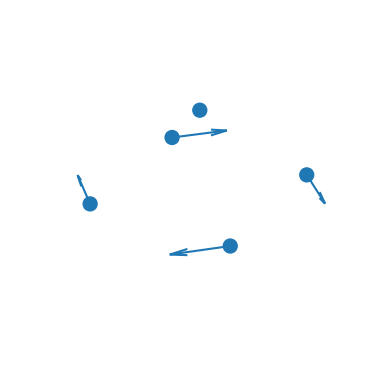

In [9]:
irrep = 1

initial_coords_test = np.zeros(np.shape(mechanical_rep)[1])
initial_coords_test[3] = 1 # init vector
# initial_coords_test[7] = -1 # init vector
sym_adap = get_symmetry_adapted_modes(initial_coords_test, irrep, mechanical_rep, character_table_C4v, elements_per_class_C4v)
print(initial_coords_test.reshape(5,3))
fucking_work = sym_adap.reshape(5,3).T

ax = plt.figure().add_subplot(projection='3d')

# Make the grid
x, y, z = np.meshgrid(np.arange(3),
                      np.arange(3),
                      np.arange(3))

# ax.quiver(x, y, z, u, v, w, length=1/2, normalize=True)
ax.quiver(
    atom_spatial_coordinates_C4v[0,:],
    atom_spatial_coordinates_C4v[1,:],
    atom_spatial_coordinates_C4v[2,:],
    fucking_work[0,:],
    fucking_work[1,:],
    fucking_work[2,:],
    length=0.75,
    normalize=True
    )
ax.scatter(atom_spatial_coordinates_C4v[0,:],atom_spatial_coordinates_C4v[1,:],atom_spatial_coordinates_C4v[2,:], s=100, alpha=1)
ax.set_xlim3d(-1.5,1.5)
ax.set_ylim3d(-1.5,1.5)
ax.set_zlim3d(-1.5,1.5)

ax.set_axis_off()

plt.show()
